In [1]:
# La clase `Model` se hace cargo de los atributos a nivel del modelo, maneja los agentes. 
# Cada modelo puede contener múltiples agentes y todos ellos son instancias de la clase `Agent`.
from mesa import Agent, Model

# Debido a que necesitamos un solo agente por celda elegimos `SingleGrid` que fuerza un solo objeto por celda.
from mesa.space import MultiGrid

from mesa.batchrunner import BatchRunnerMP
# Con `SimultaneousActivation` hacemos que todos los agentes se activen de manera simultanea.
from mesa.time import SimultaneousActivation

# Vamos a hacer uso de `DataCollector` para obtener el grid completo cada paso (o generación) y lo usaremos para graficarlo.
from mesa.datacollection import DataCollector

# mathplotlib lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos.
import numpy as np
import pandas as pd

import itertools

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

## Creacion de Agentes, Modelos y funcion para colorear output grid

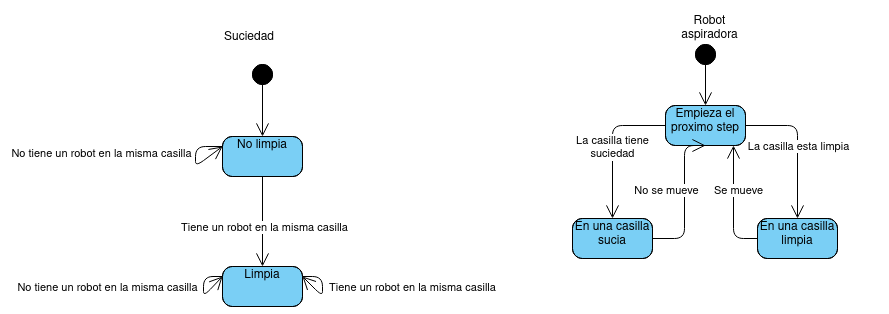

In [1]:
from IPython.display import Image
Image(filename='/home/salypimientado/Desktop/Screenshot from 2021-11-09 20-33-57.png') 

In [2]:
def get_grid(model):
    dimensions = model.grid.width, model.grid.height
    grid = np.zeros(dimensions)
    for x, line in enumerate(grid):
        for y, _ in enumerate(line):
            # amount of dirt agents in cell
            dirt = len(list(filter(lambda agent: isinstance(agent,DirtAgent) and not agent.is_clean, model.grid.iter_neighbors((x,y), False, True, 0))))
            #print(f'{x=} {y=} {dirt=}')
            # len of dirt agents in cell
            vacuums = len(list(filter(lambda agent: isinstance(agent,VacuumAgent), model.grid.iter_neighbors((x,y), False, True, 0))))
            #print(f'{vacuums=}')
            if dirt != 0 and vacuums == 0:
                grid[x][y] = -10
            elif dirt == 0 and vacuums != 0:
                grid[x][y] = 10
            elif dirt != 0 and vacuums != 0:
                grid[x][y] = 5
            elif dirt == 0 and vacuums == 0:
                grid[x][y] = 0
        
    return grid

def get_dirt_amount(model):
    return model.dirt_amount

    

class VacuumAgent(Agent):
    def __init__(self,id, x, y, model):
        super().__init__(id,model)
        self.id = id
        self.coords = x,y
        self.model = model
        self.next_pos = None
        self.total_steps = 0
    
    def step(self):
        need_to_clean = any([isinstance(agent,DirtAgent) and not agent.is_clean for agent in self.model.grid.iter_neighbors(self.coords, False, True, 0)])
        if not need_to_clean:
            valid_neighborhood = [cell for cell in self.model.grid.iter_neighborhood(self.coords,True,False,1)]
            # insert current coords to replace unreachable space
            valid_neighborhood.extend([self.coords for _ in range(8-len(valid_neighborhood))])
            
            choices = valid_neighborhood
            # choose next position
            self.next_pos =choices[np.random.choice(len(choices))]
        else:
            self.next_pos = self.coords
    def advance(self):
        if self.next_pos != self.coords:
            self.total_steps = self.total_steps + 1
        self.coords = self.next_pos
        self.model.grid.move_agent(self,self.coords)

class DirtAgent(Agent):
    def __init__(self,id, x, y, model):
        super().__init__(id, model)
        self.id = id
        self.coords = x, y
        self.model = model
        self.next_state = None
        self.is_clean = False
        
    def step(self):
        # if there are any vacuum agents in the same cell next state is clean
        if not self.is_clean:
            self.next_state = any([isinstance(agent,VacuumAgent) for agent in self.model.grid.iter_neighbors(self.coords, False, True, 0)])
            if self.next_state == True:
                self.model.dirt_amount = self.model.dirt_amount-1
        
    def advance(self):
        self.is_clean = self.is_clean or self.next_state
        
class CleaningModel(Model):
    def __init__(self,M,N,vacuums,dirty_percentage,exec_time):
        self.grid = MultiGrid(M,N,False)
        self.x = M
        self.y = N
        self.schedule = SimultaneousActivation(self)
        self.dirt_amount = int(M*N*(dirty_percentage*100))//100
        self.running = True
        self.exec_time = float(exec_time)
        self.start_time = time.time()
        self.cur_time = 0
        
        id = 0
        shuffled_dirt_coords = list(self.grid.coord_iter())
        np.random.shuffle(shuffled_dirt_coords)
        for (content, x, y) in shuffled_dirt_coords[:self.dirt_amount]:
            a = DirtAgent(id, x, y, self)
            self.grid.place_agent(a, (x, y))
            self.schedule.add(a)
            id = id + 1
        
        for _ in itertools.repeat(None,vacuums):
            a = VacuumAgent(id, 1, 1, self)
            self.grid.place_agent(a, (1, 1))
            self.schedule.add(a)
            id = id + 1
    
                
        self.datacollector = DataCollector(
            model_reporters={"Grid": get_grid, "Dirt_amount":get_dirt_amount})
    def step(self):
        if time.time() - self.start_time >= self.exec_time:
            self.running = False
            self.datacollector.collect(self)
        if self.running and time.time() - self.start_time < self.exec_time:
            self.datacollector.collect(self)
            self.schedule.step()
            self.cur_time = time.time() - self.start_time 
            if self.dirt_amount == 0:
                self.running = False

## Correr modelo con combinaciones de variables para ver correlaciones entre variables de entrada y salidas

In [11]:
M = [10,20,30]
N = [10,20,30]
num_aspiradoras = [1,5,10]
porc_celdas_sucias = [0.1,0.5,0.9]
tiempo_ejecucion = [1,3,5]
exec_settings = dict(M=M,N=N,vacuums=num_aspiradoras,exec_time=tiempo_ejecucion,dirty_percentage=porc_celdas_sucias)

model_reporter = {"Time until done": lambda m: (m.cur_time), "Clean Percentage": lambda m: 1 - m.dirt_amount/(m.x*m.y) , "Average_steps_per_agent": lambda m:(lambda lst: sum(lst)/len(lst))([agent.total_steps for agent in m.schedule.agent_buffer() if isinstance(agent,VacuumAgent)])}
    # Imprimimos el tiempo que le tomó correr al modelo.
param_run = BatchRunnerMP(CleaningModel, None, variable_parameters=exec_settings, model_reporters=model_reporter)

BatchRunner MP will use 8 processors.


In [ ]:
param_run.run_all()

## Convertir resultado de batch run, pasarlo a dataframe y quitarle una columna innecesaria

In [13]:
df = param_run.get_model_vars_dataframe()
df = df.drop(["Run"],axis=1)
df.describe()

,M,N,vacuums,exec_time,dirty_percentage,Average_steps_per_agent,Clean Percentage,Time until done
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,20.000000,20.000000,5.333333,3.000000,0.500000,453.069959,0.857517,1.958402
std,8.181818,8.181818,3.689386,1.636364,0.327273,258.286925,0.219079,1.412602
min,10.000000,10.000000,1.000000,1.000000,0.100000,54.100000,0.134444,0.070066
25%,10.000000,10.000000,1.000000,1.000000,0.100000,221.400000,0.788750,1.000630
50%,20.000000,20.000000,5.000000,3.000000,0.500000,406.400000,0.975000,1.164632
75%,30.000000,30.000000,10.000000,5.000000,0.900000,685.050000,1.000000,3.001047
max,30.000000,30.000000,10.000000,5.000000,0.900000,930.000000,1.000000,5.007882


## Sacar la matriz de correlacion y hacer un heatmap

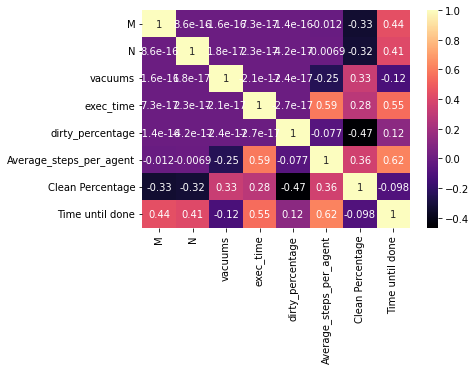

In [14]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()

colormap = sn.color_palette("magma", as_cmap=True)

sn.heatmap(corrMatrix, annot=True, cmap=colormap)
plt.show()

## Correr una vez el modelo para ver como funciona el modelo con una grafica

<AxesSubplot:>

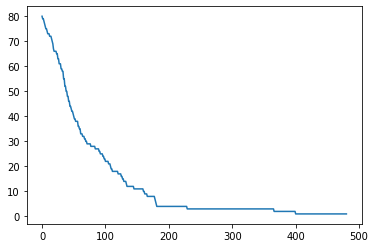

In [22]:
start = time.time()
exec_time = 1
gens = 0
X = 10
Y = 10
vacuums = 3
dirt_percentage = 0.8
model = CleaningModel(X, Y, vacuums, dirt_percentage, exec_time)
while model.running:
    model.step()
    gens = gens +1

dirt = model.datacollector.get_model_vars_dataframe()['Dirt_amount']
all_grid = model.datacollector.get_model_vars_dataframe()['Grid']
dirt.plot()

In [23]:
%%capture

fig, axs = plt.subplots(figsize=(X,Y))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0], cmap=plt.cm.coolwarm)

def animate(i):
    patch.set_data(all_grid.iloc[i])
    
anim = animation.FuncAnimation(fig, animate, frames=gens)

In [24]:
anim

### Conclusiones

Viendo el heatmap de una serie de combinaciones de variables de entrada y la , podemos llegar a las siguientes conclusiones:


1. Entre mas grande sea el cuarto a limpiar, menos limpio va a quedar
2. Las variables de entrada que mas afectan positivamente al porcentaje de casillas limpias son el numero de aspiradoras y el tiempo de ejecucion
3. El porcentaje de casillas sucias inicial es la variable con mas impacto en el porcentaje de casillas limpias finales
4. Por lo general, no suele acabar con el tiempo dado asi que entre mas le demos mas tiempo se va a tardar en terminar, limpie todo o no
5. El tiempo de ejecucion esta altamente correlacionado con el tiempo que tomaba acabar al modelo y al tiempo maximo de ejecucion
6. A como pasa el tiempo los robots se vuelven menos efectivos porque hay mas espacio limpio por el que pueden pasar